In [2]:
#uncomment this to see the names of the different configurations that can be loaded in
#import config
#print('List of files that can be loaded in:')
#dir(config)

In [4]:
#import configuration for selected file
from config import Mosaic25 as field
from config import dpath, dpathalt, detectsigma, bkgbox, ds9path #import additional common paramters

#set wavelength
wavelength=25

In [5]:
#import all required packages
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import subprocess

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord,Angle 
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry, CircularAperture
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9, write_ds9, CircleSkyRegion

In [10]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

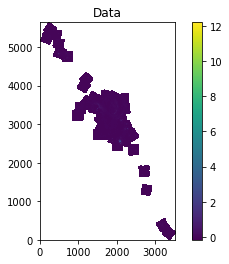

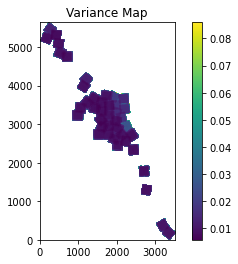

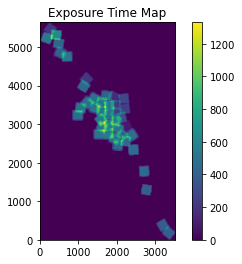

In [11]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

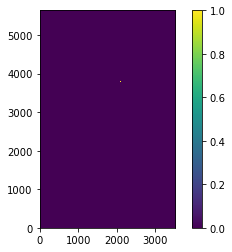

In [12]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<field.m1cut,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed
#the above can be adjusted if there are obvious sources near the edges of the map

#plot any of the mask to verify
plt.figure()
plt.imshow(mask,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [13]:
#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = detectsigma*bkg_rms

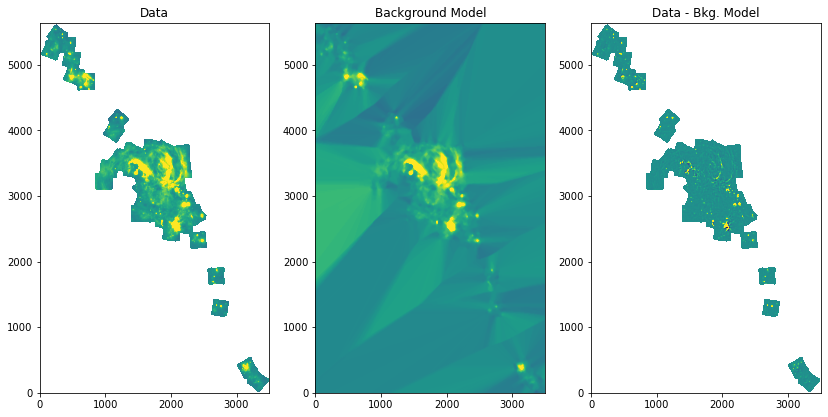

In [14]:
#plot the data and background model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,10))
ax1.set_title('Data')

#set the image limits for the plots
minval=-0.1
maxval=0.1

ax1.imshow(data,origin='lower',vmin=minval,vmax=maxval)
ax2.set_title('Background Model')
ax2.imshow(bkg,origin='lower',vmin=minval,vmax=maxval)
ax3.set_title('Data - Bkg. Model')
ax3.imshow(data_bkgsub,origin='lower',vmin=minval,vmax=maxval)
plt.show()

In [15]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

#removed labels that exist in masked region
if field.m2lims is not None:
    mask2=np.zeros(np.shape(mask))
    for lim in field.m2lims:
        mask2[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm.remove_masked_labels(mask2.astype('bool'))

In [16]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3) 
if field.m3lims is not None:
    mask3=np.zeros(np.shape(mask))
    for lim in field.m3lims:
        mask3[lim[0]:lim[1],lim[2]:lim[3]]=1
    segm_deblend.remove_masked_labels(mask3.astype('bool'))

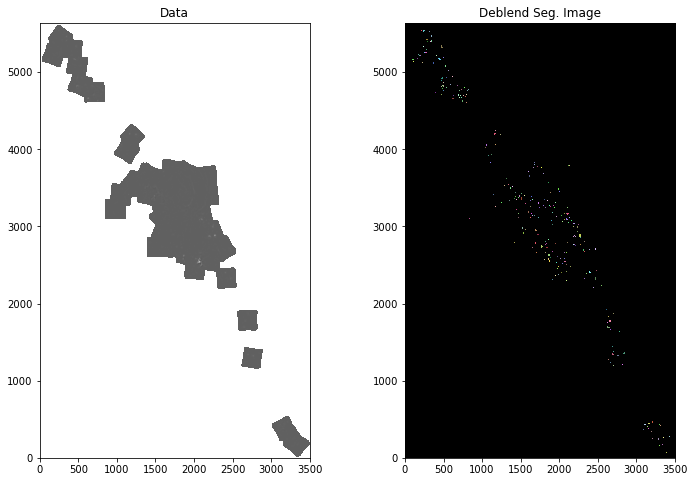

In [17]:
#make plot of segmentation image to show detected sources side by side with data
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Deblend Seg. Image')
plt.show()

In [18]:
#now lets look at building a catalog from the deblended segmentation map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [19]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#change format of columns to save fewer decimal places
for col in tbl2.colnames:
    if col!='sky_centroid': #skip sky centroid since its problematic in this context
        tbl2[col].info.format = '%.4G'
    
#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,3313,3.986,"266.11076071409605,-29.549334095733265",0.01891,-0.006832,-0.07515,11,1.512,0.6067,17.83,0.6514,-1.329,2.503,0.9159,0.5986,2.491,2.712,2.108,2.256,3.094,0.4434,0.6961,-0.006835,-0.006829,0.0002478,0.5315
2,3347,3.921,"266.1022992023817,-29.54932569303847",0.01904,-0.02186,-0.1312,6,0.7162,0.5567,26.2,2.199,-1.011,2.977,0.629,0.2226,1.286,1.51,1.018,1.558,3.344,0.237,0.5076,-0.02194,-0.02196,0.0004701,0.3327
3,3183,108.2,"266.14269117640123,-29.527174813146562",0.0281,-0.01233,-0.06167,5,0.7572,0.4605,-74.76,4.511,1.507,1.949,0.7939,0.3919,1.644,1.476,0.5302,1.472,2.785,0.1799,0.4892,-0.01236,-0.01236,0.000172,0.2572
4,3261,155.5,"266.1235101259979,-29.517059559202853",0.02037,0.002146,0.3283,153,4.624,2.411,-20.31,0.06187,0.08158,0.157,0.8533,0.4787,1.918,8.683,8.369,3.087,2.085,4.314,1.239,0.002485,0.001835,0.002222,3.5
5,3366,155.1,"266.09772969048504,-29.51707741299882",0.01903,0.009311,0.4283,46,1.955,1.706,46.58,0.3049,-0.08178,0.3004,0.4882,0.1273,1.146,4.32,3.8,2.084,2.582,1.505,0.6762,0.009158,0.009177,0.0005579,1.436
6,3287,161.6,"266.1171534401101,-29.51572255555539",0.02046,0.01843,0.7188,39,1.98,1.516,52.42,0.3682,-0.1742,0.322,0.6435,0.2346,1.306,4.153,7.135,2.508,3.292,1.397,0.6193,0.01841,0.01847,0.001029,1.207
7,3328,173.4,"266.1071076601792,-29.513184115208496",0.01908,0.02444,5.792,237,5.107,3.156,24.28,0.04883,-0.0465,0.08988,0.7861,0.3819,1.618,9.997,11.66,1.772,1.008,10.35,1.52,0.02387,0.02413,0.001757,3.847
8,3134,170,"266.15471389384214,-29.514039916115717",0.03211,-0.003283,-0.02627,8,1.064,0.5786,-27.68,1.337,1.731,2.533,0.8394,0.4564,1.84,2.017,1.046,1.468,2.665,0.3411,0.6136,-0.003328,-0.003343,0.0002645,0.4354


In [20]:
#write out the resulting table to file
ascii.write(tbl2, field.name+'_'+str(wavelength)+'um_seg.dat', overwrite=True)

Now lets try another other source detection method for comparison

In [21]:
from photutils import DAOStarFinder,IRAFStarFinder

In [22]:
#do statistics on image - daofind requires a single value for threshold rather than a 2d map
mean, median, std = sigma_clipped_stats(data_bkgsub, sigma=3.0)  
print('Data mean, med, std: ',(mean, median, std))  

print('Seg. Threshold mean/median comparison: ', (np.mean(threshold)/3.,np.median(threshold)/3.))

Data mean, med, std:  (-3.8941750873596575e-05, -0.00020221201819059032, 0.007366027061793335)
Seg. Threshold mean/median comparison:  (0.009217571146316666, 0.00889722579438354)


In [23]:
#now run starfinder to find sources 
daofind = DAOStarFinder(fwhm=4.2, threshold=3*std)
DAOsources = daofind(data_bkgsub,mask=mask)

StarFinder = IRAFStarFinder(fwhm=4.2, threshold=3*std)
IRAFsources = StarFinder(data_bkgsub,mask=mask)

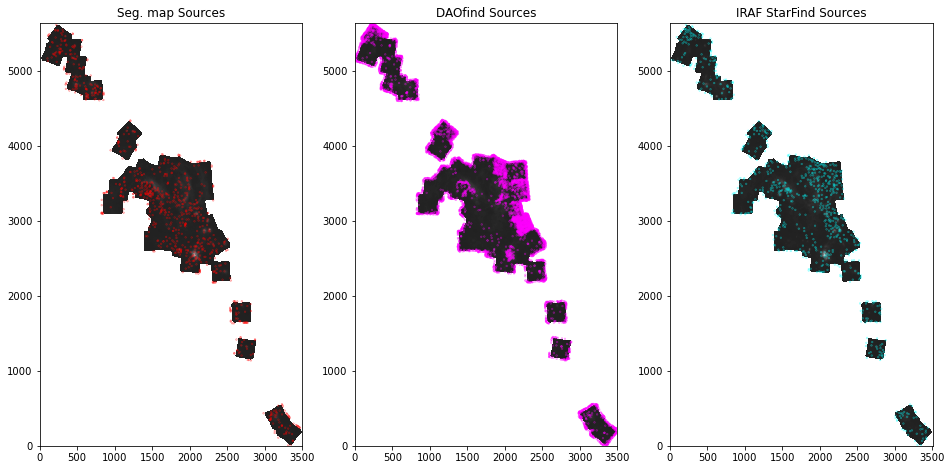

In [24]:
#plot data with apertures on detected sources
Dpositions = np.transpose((DAOsources['xcentroid'], DAOsources['ycentroid']))
Dapertures = CircularAperture(Dpositions, r=4.)
Ipositions = np.transpose((IRAFsources['xcentroid'], IRAFsources['ycentroid']))
Iapertures = CircularAperture(Ipositions, r=4.)
Spositions = np.transpose((tbl2['xcentroid'], tbl2['ycentroid']))
Sapertures = CircularAperture(Spositions, r=4.)

norm = ImageNormalize(stretch=SqrtStretch())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 10))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Seg. map Sources')
Sapertures.plot(color='red', lw=1.5, alpha=0.5,axes=ax1)

ax2.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax2.set_title('DAOfind Sources')
Dapertures.plot(color='magenta', lw=1.5, alpha=0.5,axes=ax2)

ax3.imshow(data, origin='lower', cmap='Greys_r',norm=norm)
ax3.set_title('IRAF StarFind Sources')
Iapertures.plot(color='cyan', lw=1.5, alpha=0.5,axes=ax3)

plt.show()

In [25]:
#lets add ra, dec coordinates of sources to DAOsources table
Nsources=len(DAOsources['id'])
scs=[]

for i in range(0,Nsources):
    xcoord=DAOsources['xcentroid'][i]
    ycoord=DAOsources['ycentroid'][i]
    sc=pixel_to_skycoord(xcoord,ycoord,wcsmap)
    scs.append(sc)
    
DAOsources['sky_centroid']=scs

#change format of columns to save fewer decimal places
for col in DAOsources.colnames:
    if col!='sky_centroid': #skip sky centroid since its problematic in this context
        DAOsources[col].info.format = '%.4G'

#pring DAO sources table?
#DAOsources

In [26]:
#write out the resulting table to file
ascii.write(DAOsources, field.name+'_'+str(wavelength)+'um_dao.dat', overwrite=True)

In [27]:
#create ds9 regions file for segmentation map sources
#start by getting lists of coords from table
sourcecoords=tbl2['sky_centroid']

#set size of regions 
radius = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"

#loop through and create region instances for each source
regions=[]
for i in range(0,len(sourcecoords)):
    region = CircleSkyRegion(sourcecoords[i], radius)
    regions.append(region)
    
#write out region file
write_ds9(regions, field.name+'_seg.reg')


In [28]:
#change the color of the regions to red - no built in way to do this in regions package :-/
with open(field.name+'_seg.reg', 'r+') as f:
    text = f.read()
    text = re.sub(r'\)', r') # color=red', text)
    f.seek(0)
    f.write(text)
    f.truncate()

In [29]:
#create ds9 region file for DAO sources

sourcecoords=DAOsources['sky_centroid']

regions=[]
for i in range(0,len(sourcecoords)):
    region = CircleSkyRegion(sourcecoords[i], radius)
    regions.append(region)
    
#write out region file
write_ds9(regions, field.name+'_DF.reg')

In [30]:
#change the color of the regions to cyan - no built in way to do this in regions package :-/
with open(field.name+'_DF.reg', 'r+') as f:
    text2 = f.read()
    text2 = re.sub(r'\)', r') # color=cyan', text2)
    f.seek(0)
    f.write(text2)
    f.truncate()

In [31]:
#create new region file including both sets of sources
newregtext=text+text2[45:]

with open(field.name+'.reg', 'w+') as f:
    f.seek(0)
    f.write(newregtext)
    f.truncate()

In [32]:
#open ds9 and load in the region file that was just saved
if ds9path is not None:
    subprocess.Popen(ds9path+' '+field.filename+ ' -mode region -regions load '+field.name+'.reg') 

In [30]:
#delete any regions for any spurious detections...
#add new regions for any sources that appear to be missed...
#save new region file as field+'_update.reg'

In [31]:
#this can be used to read the regions file back in after modification
#load in sources from region file. Option to use original regions or a new regions file
#regfile=field+'.reg'
#regfile=fieldconfig.field+'_update.reg'

#new_regions = read_ds9(regfile)

In [32]:
#new_regions